**Question 4**

**Step 3**

Training a convnet from scratch on a small dataset


The relevance of deep learning for small-data problems

Downloading the data

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"lauralu521","key":"dd65f9e99c75adc5f211aee4315313c6"}'}

In [2]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle competitions download -c dogs-vs-cats

100% 810M/812M [00:35<00:00, 21.6MB/s]
100% 812M/812M [00:35<00:00, 23.9MB/s]


In [4]:
!unzip -qq dogs-vs-cats.zip

In [5]:
!unzip -qq train.zip

Copying images to training, validation, and test directories.

In [6]:
import os, shutil, pathlib

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

make_subset("train", start_index=0, end_index=2000)
make_subset("validation", start_index=2000, end_index=2500)
make_subset("test", start_index=2500, end_index=3000)

Building the model
Instantiating a small convnet for dogs vs. cats classification

In [7]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [8]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                         

Configuring the model for training

In [9]:
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

Data preprocessing
Using image_dataset_from_directory to read images

In [10]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 4000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [11]:
import numpy as np
import tensorflow as tf
random_numbers = np.random.normal(size=(2000, 16))
dataset = tf.data.Dataset.from_tensor_slices(random_numbers)

In [12]:
for i, element in enumerate(dataset):
    print(element.shape)
    if i >= 2:
        break

(16,)
(16,)
(16,)


In [13]:
batched_dataset = dataset.batch(32)
for i, element in enumerate(batched_dataset):
    print(element.shape)
    if i >= 2:
        break

(32, 16)
(32, 16)
(32, 16)


In [14]:
reshaped_dataset = dataset.map(lambda x: tf.reshape(x, (4, 4)))
for i, element in enumerate(reshaped_dataset):
    print(element.shape)
    if i >= 2:
        break

(4, 4)
(4, 4)
(4, 4)


Displaying the shapes of the data and labels yielded by the Dataset

In [15]:
for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


Fitting the model using a Dataset

In [16]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
125/125 [==============================] - 24s 80ms/step - loss: 0.7173 - accuracy: 0.5098 - val_loss: 0.6956 - val_accuracy: 0.5000
Epoch 2/30
125/125 [==============================] - 8s 64ms/step - loss: 0.6967 - accuracy: 0.5550 - val_loss: 0.6885 - val_accuracy: 0.5170
Epoch 3/30
125/125 [==============================] - 7s 53ms/step - loss: 0.6784 - accuracy: 0.6033 - val_loss: 0.6737 - val_accuracy: 0.6200
Epoch 4/30
125/125 [==============================] - 8s 62ms/step - loss: 0.6012 - accuracy: 0.6695 - val_loss: 0.5584 - val_accuracy: 0.7180
Epoch 5/30
125/125 [==============================] - 10s 78ms/step - loss: 0.5639 - accuracy: 0.7155 - val_loss: 0.5150 - val_accuracy: 0.7500
Epoch 6/30
125/125 [==============================] - 7s 54ms/step - loss: 0.5081 - accuracy: 0.7520 - val_loss: 0.5634 - val_accuracy: 0.7330
Epoch 7/30
125/125 [==============================] - 7s 53ms/step - loss: 0.4716 - accuracy: 0.7857 - val_loss: 0.4898 - val_accuracy: 0.76

Displaying curves of loss and accuracy during training

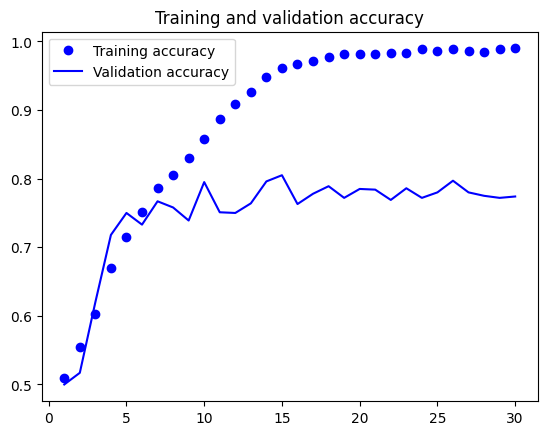

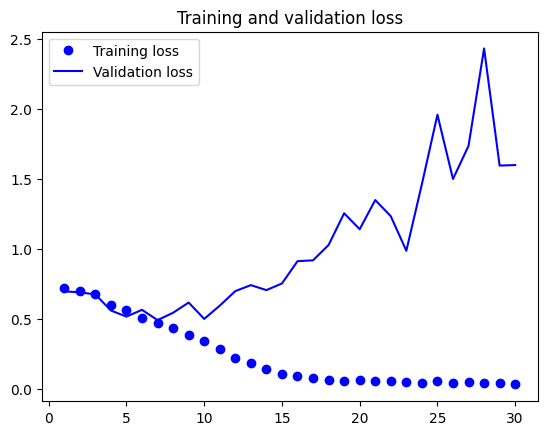

In [17]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

Evaluating the model on the test set

In [18]:
test_model = keras.models.load_model("convnet_from_scratch.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 2s 43ms/step - loss: 0.5353 - accuracy: 0.7460
Test accuracy: 0.746


Using data augmentation
Define a data augmentation stage to add to an image model

In [19]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

Displaying some randomly augmented training images

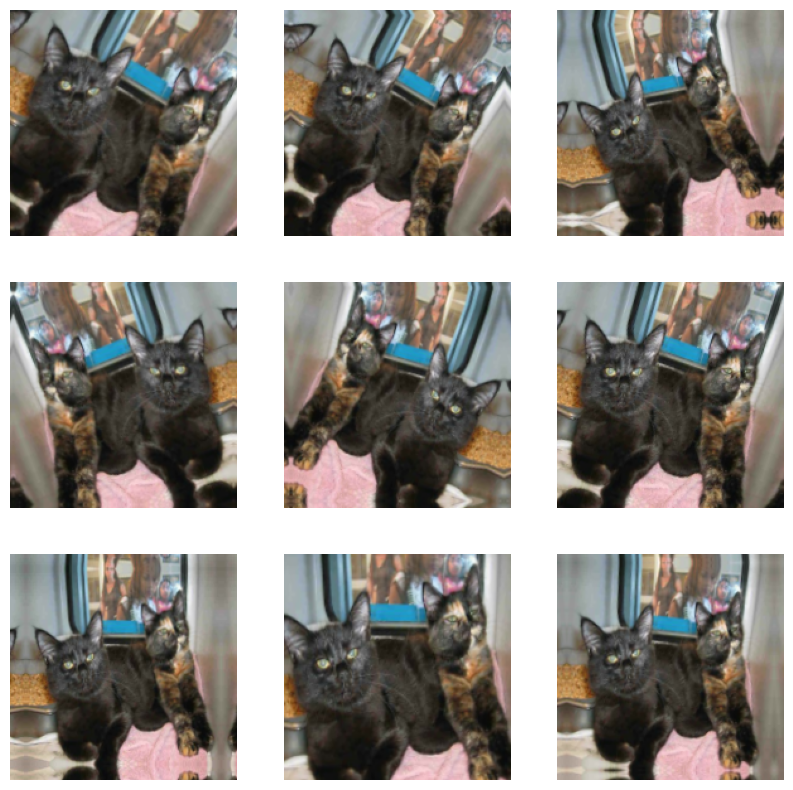

In [20]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

Defining a new convnet that includes image augmentation and dropout

In [21]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

Training the regularized convnet

In [22]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=100,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/100
125/125 [==============================] - 10s 64ms/step - loss: 0.6960 - accuracy: 0.5080 - val_loss: 0.6897 - val_accuracy: 0.5970
Epoch 2/100
125/125 [==============================] - 7s 54ms/step - loss: 0.6897 - accuracy: 0.5505 - val_loss: 0.6688 - val_accuracy: 0.5750
Epoch 3/100
125/125 [==============================] - 8s 63ms/step - loss: 0.6528 - accuracy: 0.6165 - val_loss: 0.5896 - val_accuracy: 0.6850
Epoch 4/100
125/125 [==============================] - 8s 60ms/step - loss: 0.6302 - accuracy: 0.6570 - val_loss: 0.5940 - val_accuracy: 0.6910
Epoch 5/100
125/125 [==============================] - 7s 57ms/step - loss: 0.6161 - accuracy: 0.6535 - val_loss: 0.5703 - val_accuracy: 0.7070
Epoch 6/100
125/125 [==============================] - 8s 63ms/step - loss: 0.5936 - accuracy: 0.6840 - val_loss: 0.5608 - val_accuracy: 0.7070
Epoch 7/100
125/125 [==============================] - 8s 62ms/step - loss: 0.5848 - accuracy: 0.6998 - val_loss: 0.5554 - val_accuracy

Evaluating the model on the test set

In [23]:
test_model = keras.models.load_model(
    "convnet_from_scratch_with_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 2s 53ms/step - loss: 0.3027 - accuracy: 0.8940
Test accuracy: 0.894


**Leveraging a pretrained model**


Feature extraction with a pretrained model

Instantiating the VGG16 convolutional base

In [24]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))

58889256/58889256 [==============================] - 4s 0us/step


In [25]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

Fast feature extraction without data augmentation

Extracting the VGG16 features and corresponding labels

In [26]:
import numpy as np

def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels =  get_features_and_labels(train_dataset)
val_features, val_labels =  get_features_and_labels(validation_dataset)
test_features, test_labels =  get_features_and_labels(test_dataset)

1/1 [==============================] - 0s 20ms/step


In [27]:
train_features.shape

(4000, 5, 5, 512)

Defining and training the densely connected classifier

In [28]:
inputs = keras.Input(shape=(5, 5, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
      filepath="feature_extraction.keras",
      save_best_only=True,
      monitor="val_loss")
]
history = model.fit(
    train_features, train_labels,
    epochs=20,
    validation_data=(val_features, val_labels),
    callbacks=callbacks)

Epoch 1/20
125/125 [==============================] - 2s 6ms/step - loss: 14.3739 - accuracy: 0.9408 - val_loss: 4.8303 - val_accuracy: 0.9750
Epoch 2/20
125/125 [==============================] - 0s 4ms/step - loss: 3.5020 - accuracy: 0.9772 - val_loss: 6.0437 - val_accuracy: 0.9740
Epoch 3/20
125/125 [==============================] - 1s 5ms/step - loss: 1.7283 - accuracy: 0.9887 - val_loss: 4.7099 - val_accuracy: 0.9770
Epoch 4/20
125/125 [==============================] - 0s 4ms/step - loss: 1.6767 - accuracy: 0.9912 - val_loss: 6.0335 - val_accuracy: 0.9700
Epoch 5/20
125/125 [==============================] - 1s 4ms/step - loss: 0.6061 - accuracy: 0.9948 - val_loss: 9.2737 - val_accuracy: 0.9630
Epoch 6/20
125/125 [==============================] - 1s 5ms/step - loss: 0.9830 - accuracy: 0.9942 - val_loss: 6.2982 - val_accuracy: 0.9700
Epoch 7/20
125/125 [==============================] - 1s 5ms/step - loss: 0.4484 - accuracy: 0.9958 - val_loss: 6.8562 - val_accuracy: 0.9680
Epoch

Plotting the results

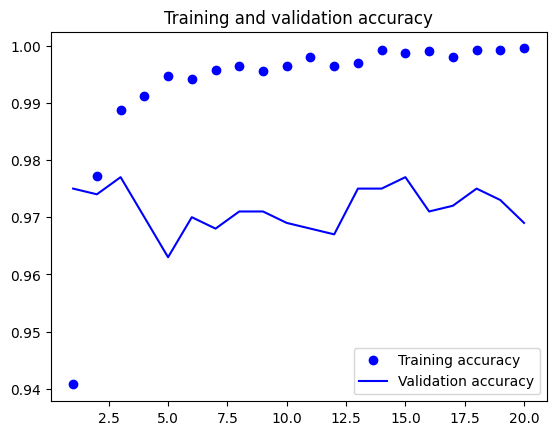

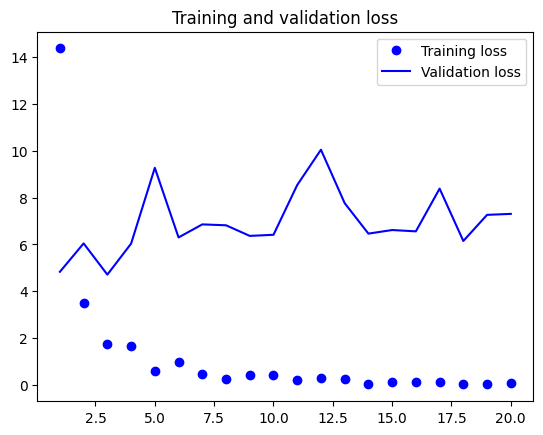

In [29]:
import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

Feature extraction together with data augmentation

Instantiating and freezing the VGG16 convolutional base

In [30]:
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)
conv_base.trainable = False

Printing the list of trainable weights before and after freezing

In [31]:
conv_base.trainable = True
print("This is the number of trainable weights "
      "before freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weights before freezing the conv base: 26


In [32]:
conv_base.trainable = False
print("This is the number of trainable weights "
      "after freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weights after freezing the conv base: 0


Adding a data augmentation stage and a classifier to the convolutional base

In [33]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [34]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="feature_extraction_with_data_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/50
125/125 [==============================] - 16s 119ms/step - loss: 12.4158 - accuracy: 0.9230 - val_loss: 6.0756 - val_accuracy: 0.9660
Epoch 2/50
125/125 [==============================] - 16s 121ms/step - loss: 7.0072 - accuracy: 0.9513 - val_loss: 4.6600 - val_accuracy: 0.9680
Epoch 3/50
125/125 [==============================] - 15s 117ms/step - loss: 5.5699 - accuracy: 0.9520 - val_loss: 3.0828 - val_accuracy: 0.9780
Epoch 4/50
125/125 [==============================] - 15s 115ms/step - loss: 4.0646 - accuracy: 0.9630 - val_loss: 3.2392 - val_accuracy: 0.9800
Epoch 5/50
125/125 [==============================] - 15s 116ms/step - loss: 3.6123 - accuracy: 0.9670 - val_loss: 3.1857 - val_accuracy: 0.9820
Epoch 6/50
125/125 [==============================] - 15s 116ms/step - loss: 3.0802 - accuracy: 0.9680 - val_loss: 3.7334 - val_accuracy: 0.9760
Epoch 7/50
125/125 [==============================] - 15s 117ms/step - loss: 1.9908 - accuracy: 0.9740 - val_loss: 3.4611 - val_a

Evaluating the model on the test set

In [35]:
test_model = keras.models.load_model(
    "feature_extraction_with_data_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 3s 87ms/step - loss: 1.2819 - accuracy: 0.9720
Test accuracy: 0.972


Fine-tuning a pretrained model

In [36]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

Freezing all layers until the fourth from the last

In [37]:
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

Fine-tuning the model

In [38]:
model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="fine_tuning.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
125/125 [==============================] - 20s 135ms/step - loss: 0.5131 - accuracy: 0.9845 - val_loss: 1.3311 - val_accuracy: 0.9760
Epoch 2/30
125/125 [==============================] - 17s 136ms/step - loss: 0.3508 - accuracy: 0.9870 - val_loss: 1.2012 - val_accuracy: 0.9750
Epoch 3/30
125/125 [==============================] - 17s 136ms/step - loss: 0.3452 - accuracy: 0.9890 - val_loss: 1.1960 - val_accuracy: 0.9810
Epoch 4/30
125/125 [==============================] - 17s 134ms/step - loss: 0.2213 - accuracy: 0.9900 - val_loss: 1.1265 - val_accuracy: 0.9810
Epoch 5/30
125/125 [==============================] - 19s 150ms/step - loss: 0.3046 - accuracy: 0.9893 - val_loss: 1.1447 - val_accuracy: 0.9830
Epoch 6/30
125/125 [==============================] - 17s 132ms/step - loss: 0.2745 - accuracy: 0.9895 - val_loss: 1.2016 - val_accuracy: 0.9780
Epoch 7/30
125/125 [==============================] - 17s 137ms/step - loss: 0.2248 - accuracy: 0.9902 - val_loss: 1.0284 - val_ac

In [39]:
model = keras.models.load_model("fine_tuning.keras")
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 4s 87ms/step - loss: 1.4948 - accuracy: 0.9750
Test accuracy: 0.975
